In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import torch
import os 
from model.SimCLR import SimCLR
from model.Train import Trainer
from model.Losses import NTXentLoss
from utils.DataLoaderSimCLR import DataLoaderSimCLR as DSC
from torch.utils.data import DataLoader, random_split
from utils.Similarity import Similarity as SMY
from utils.Plotter import Plotter as PL

In [ ]:
torch.cuda.empty_cache()

In [ ]:
SSH = os.getcwd() != 'c:\\Cours-Sorbonne\\M1\\Stage\\src'

In [ ]:
path_rol_comp = "C:/Cours-Sorbonne/M1/Stage/src/data/rol_compressed" 
path_rol_super_comp = "C:/Cours-Sorbonne/M1/Stage/src/data/rol_super_compressed" 
path_sim_rol_extracted_comp = "C:/Cours-Sorbonne/M1/Stage/src/data/similaires_rol_extracted_nn_compressed" 
path_filtered = "C:/Cours-Sorbonne/M1/Stage/src/data/rol_compressed/json_filtered"
path_targets = "C:/Cours-Sorbonne/M1/Stage/src/data/rol_sim_rol_triplets/targets.npy"

if SSH:
    path_rol_comp = "../data/rol_super_compressed" 
    path_sim_rol_extracted_comp = "../data/sim_rol_super_compressed" 
    path_filtered = "../data/rol_super_compressed/json_filtered"
    path_targets = "../data/rol_sim_rol_couples/targets.npy"

## Params

In [ ]:
epochs = 50
image_size = 256
batch_size = 32
learning_rate = 1e-3
train_ratio = 0.8
val_ratio = 0.2
temperature = 0.5

In [ ]:
dataset = DSC(
    path_rol_comp, path_sim_rol_extracted_comp, path_filtered, 
    shape=(image_size, image_size), target_path=path_targets, 
    augment_halftone=True, 
    augment_test=False, use_only_rol=True, use_context=False, max_images=100
)

train_size = int(train_ratio * len(dataset))
val_size = len(dataset) - train_size

train_set, val_set = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)

In [ ]:
DSC.show_data(train_loader,use_context=False)
DSC.show_data(val_loader,use_context=False)

# Approche Supervisé

In [ ]:
model = SimCLR(feature_size=128)
optimizer = torch.optim.AdamW
loss_fn = NTXentLoss(temperature=temperature)

In [ ]:
trainer = Trainer()
trainer.set_model(model, "SimCLR-128") \
.set_optimizer(optimizer) \
.set_loss(loss_fn) 

model = trainer.fit(
    train_data=train_loader, validation_data=val_loader, learning_rate=learning_rate, 
    verbose=True, epochs=epochs, sim_clr=True, use_context=True
)

In [ ]:
trainer.save("model_simclr.pth","history_simclr.txt")

## Testing

In [ ]:
testset = DSC(
    path_rol_comp, path_sim_rol_extracted_comp, path_filtered, 
    shape=(image_size, image_size), target_path=path_targets, 
    use_only_rol=False, augment_test=False, remove_bad_pairs=True, remove_to_enhance_files=True
)

In [ ]:
test_loader = DataLoader(testset, batch_size=8, shuffle=True)
DSC.show_data(test_loader, 3)

In [ ]:
model = SimCLR(feature_size=128)
model_state = Trainer().get_model("./params/model/model_simclr.pth")
model.load_state_dict(model_state)
history = Trainer().get_history("./params/model/history_simclr.txt")

In [22]:
best_pairs, original_images, augmented_images = SMY.match_images_with_simCLR(model, test_loader=test_loader, use_context=False)

100%|██████████| 168/168 [00:44<00:00,  3.78it/s]


[INFO] Accuracy : 0.2206432311144353


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


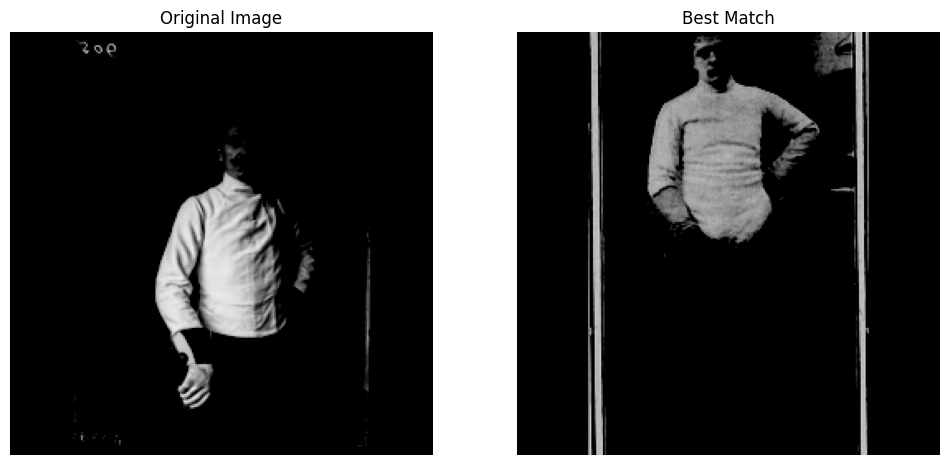

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


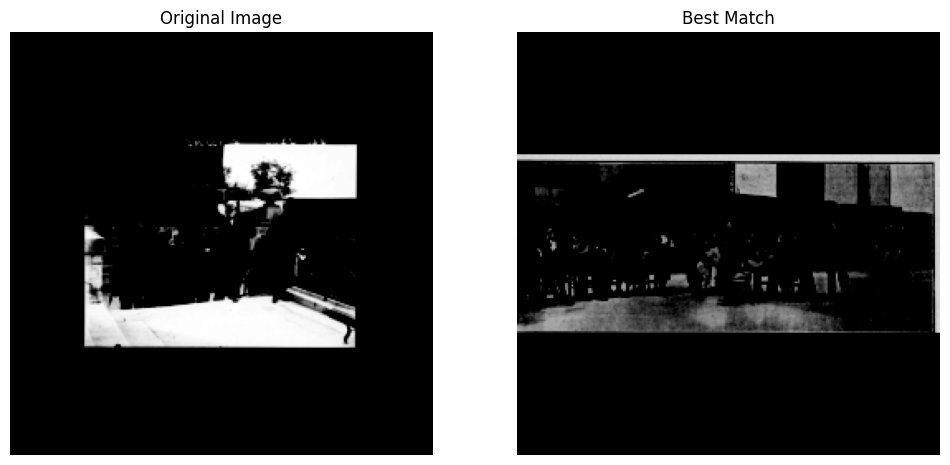

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


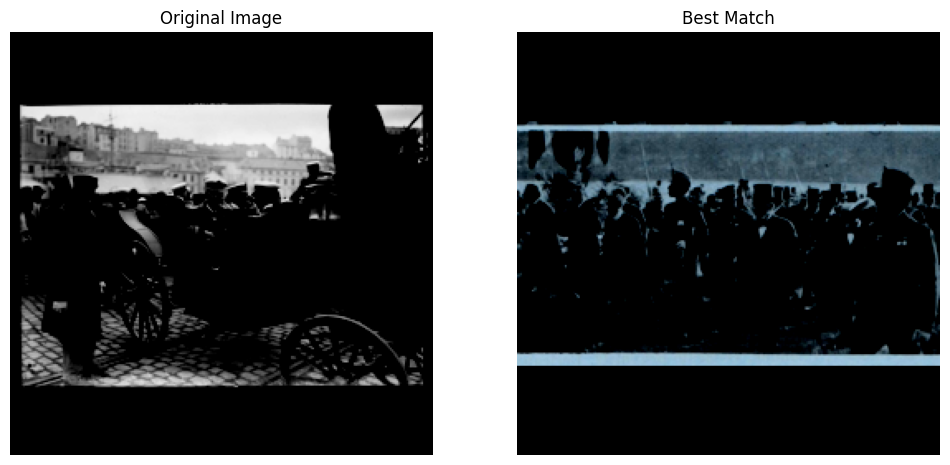

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


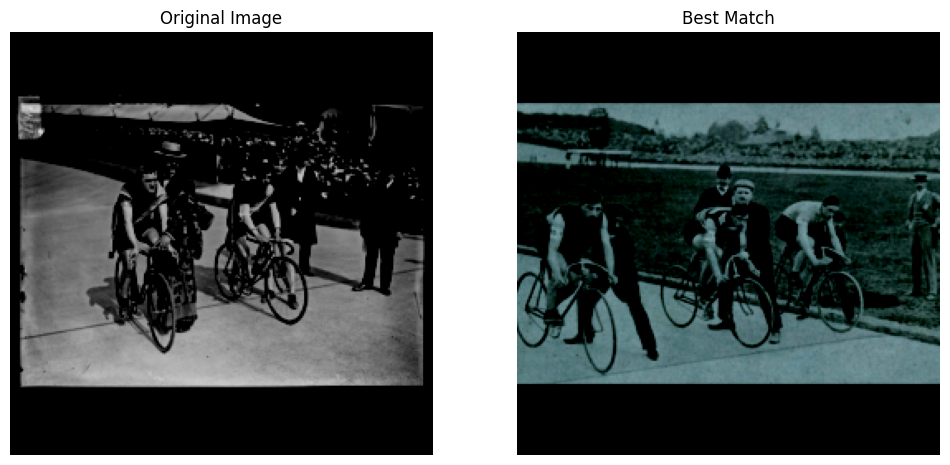

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


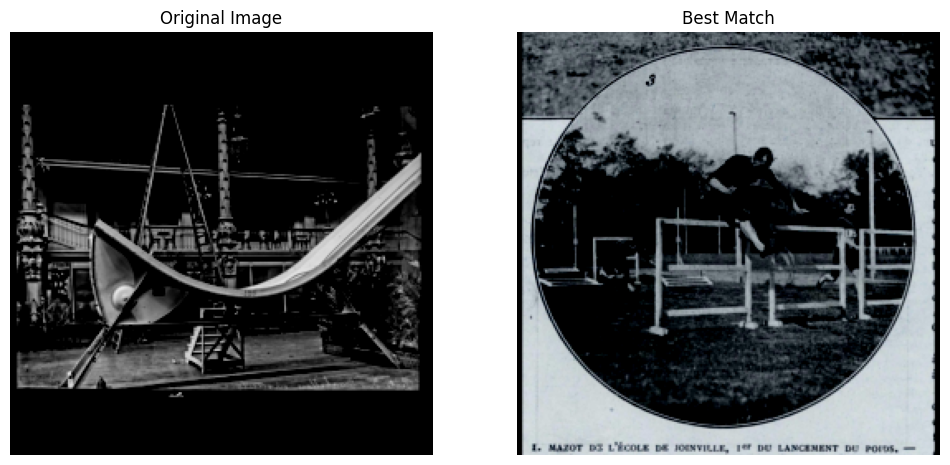

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


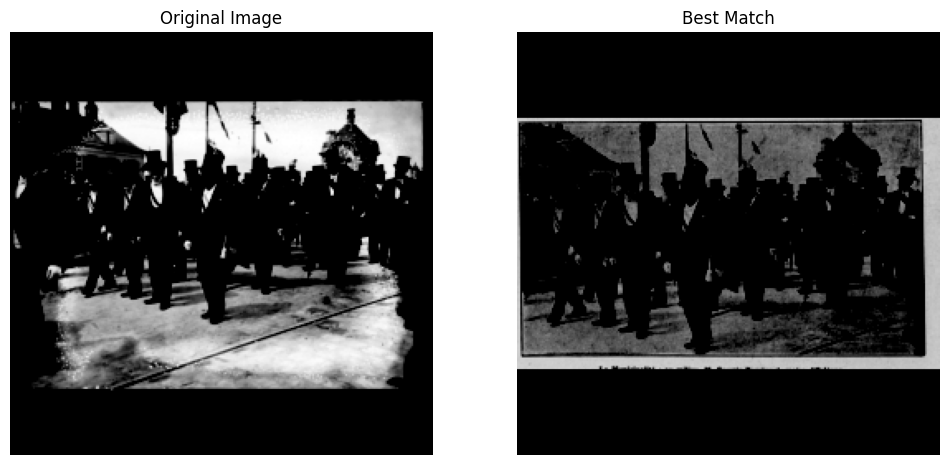

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


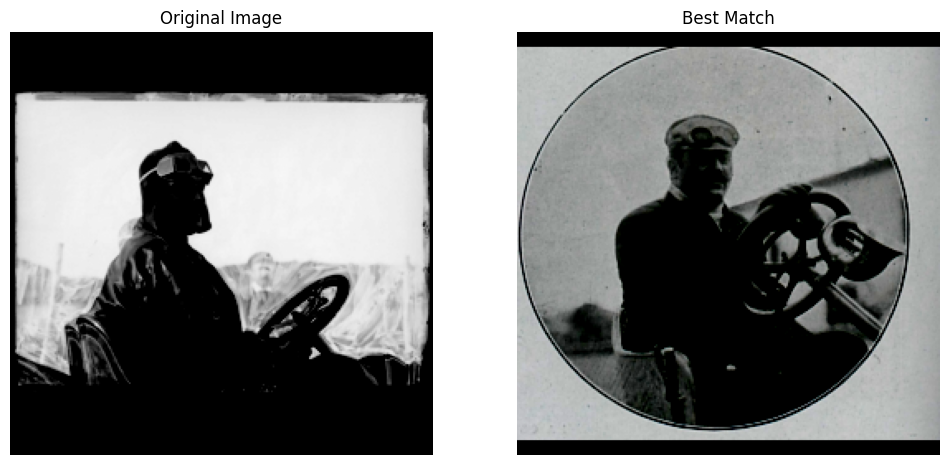

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


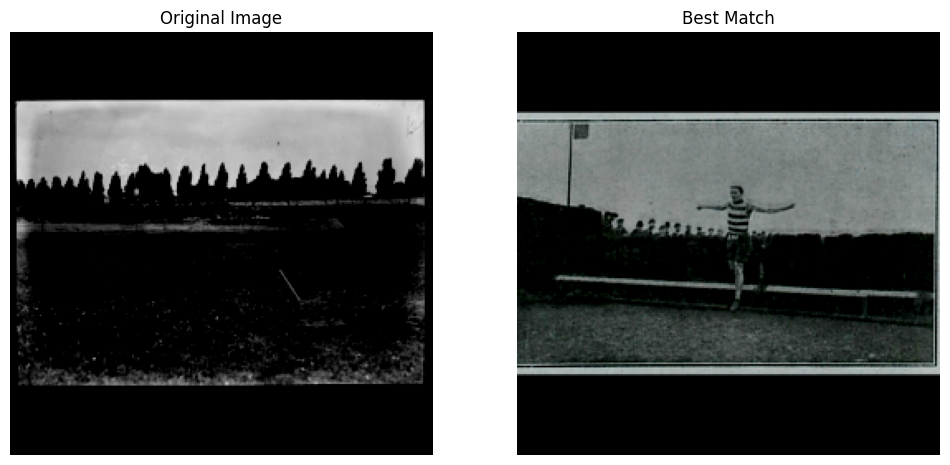

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


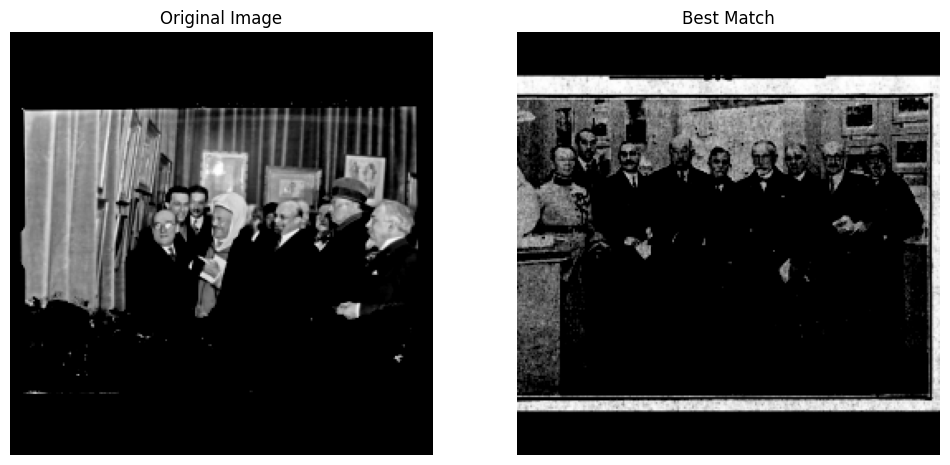

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


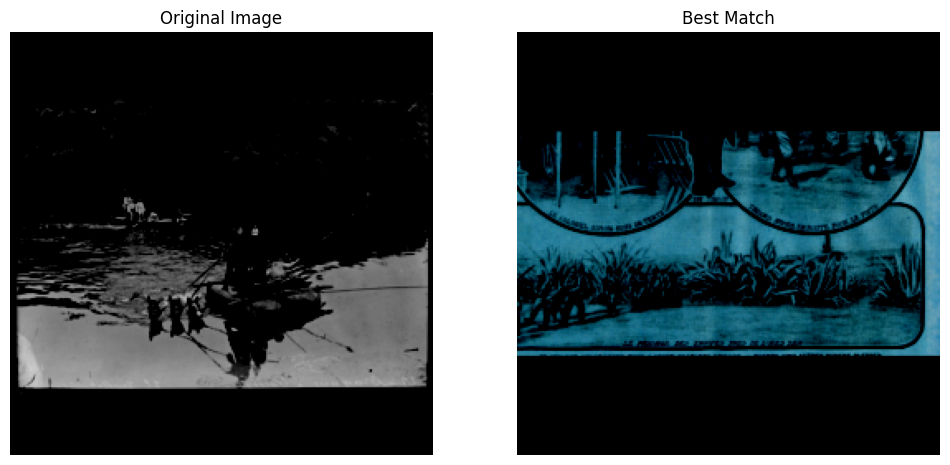

In [23]:
PL.plot_best_pairs(best_pairs, original_images, augmented_images, max_images=10)